### 黄牛检测

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# 读取数据
file_path = './data/raw_data.xlsx'
sheet_name = 'Sheet1'
data = pd.read_excel(file_path, sheet_name=sheet_name)

In [3]:
# 时间预处理
data['订单创建时间'] = pd.to_datetime(data['订单创建时间'])
data['就诊日期'] = pd.to_datetime(data['就诊日期'])

In [4]:
print(data.columns)

Index(['ID', '省份', 'APPID', 'IP_ADDRESS', '订单创建时间', '患者ID', '患者创建时间', '就诊日期',
       '就诊科室名称', '医生姓名', '状态', '商户订单号'],
      dtype='object')


In [5]:
# 写入到指定log文件中(LogBERT相关,已废弃)
def write_log(log_file_path):
    # 将数据逐行写入.log 文件
    with open(log_file_path, 'w', encoding='utf-8') as log_file:
        for index, row in data.iterrows():
            # 将每一行转换为字符串并写入日志文件
            row = row.to_dict()
            log_file.write(row['患者ID'] + " : ")
            for k, v in row.items():
                if k != "患者ID":
                    log_file.write(str(v) + " ")
            log_file.write("\n")
    print(f"Data has been written to {log_file_path}")

#### 1. 基于规则的检测

In [4]:
# 重复值筛选，找出data的seg_name字段中重复数大于limit的行, sort_add和asc_add是检测完之后添加的排序要求
def duplicate_detect(data, seg_name, limit, up=True, sort_add=[], asc_add=[]):
    assert len(sort_add) == len(asc_add)
    value_counts = data[seg_name].value_counts()
    if up:
        # 向上筛
        dup_row = data[data[seg_name].isin(value_counts[value_counts > limit].index)]
    else:
        # 向下筛
        dup_row = data[data[seg_name].isin(value_counts[value_counts < limit].index)]
    sort_by = [seg_name] + sort_add
    asc = [True] + asc_add
    dup_row = dup_row.sort_values(by=sort_by, ascending=asc)
    return dup_row

In [5]:
# 筛选出同一个dup_seg中有超过limit个unique_seg的ID字段
def unique_dup_filter(data, dup_seg, unique_seg, limit, up=True, get_row=False):
    # 确定是黄牛的行编号
    selects = []
    # IP重复检测
    dup = duplicate_detect(data, dup_seg, limit, up=up, sort_add=[unique_seg], asc_add=[True])
    print("init dup_num:", len(dup))
    if len(dup) == 0:
        return selects
    pos = 0          # 这个IP的起点
    count = 1      # 涉及多少个用户ID
    last = dup[unique_seg].iloc[0] # 上一个用户的ID
    dup_num = len(dup)
    for i in tqdm(range(1, dup_num)):
        if dup[dup_seg].iloc[i] == dup[dup_seg].iloc[pos]:
            if dup[unique_seg].iloc[i] != last:
                # 相同IP下一个新的患者
                count += 1
                last = dup[unique_seg].iloc[i]
        if dup[dup_seg].iloc[i] != dup[dup_seg].iloc[pos] or i == dup_num - 1:
            # 开始检测下一个IP
            if count > limit:
                # 达到重复人数条件
                for j in range(pos, i):
                    selects.append(dup['ID'].iloc[j])
            # 重置
            pos = i
            count = 1
            last = dup[unique_seg].iloc[i]
    print("filtered dup_num:", len(selects))
    if not get_row:
        selects.sort()
        return selects
    else:
        dup_rows = data[data['ID'].isin(selects)]
        dup_rows = dup_rows.sort_values(by=dup_seg, ascending=True)
        return dup_rows

In [20]:
# 对unique_dup_filter, 在一定范围内遍历limit(基本不用)
# 使用: limits, select_list = grid_traverse(data, '患者ID', '就诊科室名称', 5, 10)
# 仅用于分析
def grid_traverse(data, dup_seg, unique_seg, start, end, gap=1):
    limits = []
    selects_num = []
    for limit in range(start, end, gap):
        print(f"limit: {limit}")
        selects = unique_dup_filter(data, dup_seg, unique_seg, limit)
        limits.append(limit)
        selects_num.append(len(selects))
    plt.plot(limits, selects_num)
    plt.xlabel('limit')
    plt.ylabel('在超过limit个医生处挂号的患者数量')

limit: 2
init dup_num: 105623


100%|██████████| 105622/105622 [00:03<00:00, 27281.55it/s]


filtered dup_num: 81433
limit: 3
init dup_num: 61175


100%|██████████| 61174/61174 [00:02<00:00, 27159.08it/s]


filtered dup_num: 42891
limit: 4
init dup_num: 35375


100%|██████████| 35374/35374 [00:01<00:00, 27537.82it/s]


filtered dup_num: 22657
limit: 5
init dup_num: 22225


100%|██████████| 22224/22224 [00:00<00:00, 27377.59it/s]


filtered dup_num: 13615
limit: 6
init dup_num: 14443


100%|██████████| 14442/14442 [00:00<00:00, 28079.63it/s]

filtered dup_num: 8510


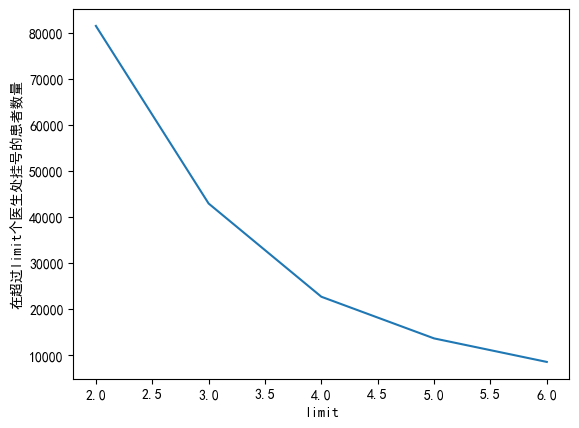

In [9]:
# 时间段过滤器，过滤出每天一段时间内的数据
# 形如daily_filter(data, '5:00:00', '5:01:00')
def daily_filter(data, start, end):
    return data[(data['订单创建时间'].dt.time >= pd.to_datetime(start).time()) &
                    (data['订单创建时间'].dt.time <= pd.to_datetime(end).time())]

In [43]:
# 时间分段统计(数据分析而非处理, 只会打印出每个小时内各个操作的次数)
def hour_count():
    print("\t\t总数\t已挂号  医保换号  已退号  窗口退号  无号退款  超时取消")
    for i in range(5, 23):
        time_filter = data[(data['订单创建时间'].dt.time >= pd.to_datetime(f'{i}:00:00').time()) &
                     (data['订单创建时间'].dt.time <= pd.to_datetime(f'{i+1}:00:00').time())]
        counts = time_filter['状态'].value_counts()
        print(f"{i}:00 - {i+1}:00 \t{len(time_filter)}\t{counts['已挂号']}\t{counts['医保换号']}\t {counts['已退号']}\t"
              f"   {counts['窗口退号']}\t   {counts['无号退款']}\t    {counts['超时取消']}\t")

# 一个小时内按分钟打印操作次数(数据分析而非处理)
def minute_line(data, hour):
    x = range(0, 55, 4)
    count = []
    for i in tqdm(range(0, 55, 4)):
        start = str(i)
        end = str(i+5)
        if len(start) < 2:
            start = '0' + start
        if len(end) < 2:
            end = '0' + end 
        time_filter = data[(data['订单创建时间'].dt.time >= pd.to_datetime(f'{hour}:{start}:00').time()) &
                     (data['订单创建时间'].dt.time <= pd.to_datetime(f'{hour}:{end}:00').time())]
        count.append(len(time_filter))
    plt.title(f"{hour}点操作数量统计")
    plt.xlabel("minute")
    plt.ylabel("操作数")
    plt.plot(x, count)

In [11]:
# 恰好在16:00进行第二天/下一周操作(因为这里面很有可能有很多正常人,不建议使用)
def hurry_sixteen(data, get_row=False):
    gap = daily_filter(data, '16:00:00', '16:00:01')
    time_diff = (gap['就诊日期'] - gap['订单创建时间']).dt.days
    hurry_row = gap[(time_diff == 0) | (time_diff == 6)]
    if get_row:
        return hurry_row
    else:
        return hurry_row['ID'].tolist()

In [58]:
# 将之前一次答案中的数据提取成列表(需要配套data文件夹中的result1/2/3...使用)
def get_list(res_id, file_path=""):
    if file_path == "":
        file_path = f'./data/result{res_id}.txt'
    with open(file_path, 'r') as file:
        lis = [int(line.strip()) for line in file]
    return lis

In [13]:
# 两个list进行对比(相比增加的,减少的,相同的)
def lis_cmp(lis1, lis2, ret=False, show=True):
    set1 = set(lis1)
    set2 = set(lis2)
    new_ele = set2 - set1
    miss_ele = set1 - set2
    same_ele = set1.intersection(set2)
    if show:
        print(f"lis1: {len(lis1)},\tlis2: {len(lis2)},\tmore: {len(new_ele)},"
            f"\tmiss: {len(miss_ele)},\tsame = {len(same_ele)}")
    if ret:
        return list(new_ele), list(miss_ele), list(same_ele)

# 与之前一次答案进行对比
def res_cmp(res_id, lis, ret=False, show=True):
    lis1 = get_list(res_id)
    res = lis_cmp(lis1, lis, ret, show)
    if ret:
        return res

In [14]:
# 将一个list写作答案(写到data/result.txt中,remove_white选项是是否去除白名单)
def write_list(lis, remove_white=True):
    if remove_white:
        white_lis = get_list(0, './data/white.txt')
        print(f"remove white: {len(set(lis).intersection(set(white_lis)))}")
        lis = list(set(lis) - set(white_lis))
        lis.sort()
    # 打开一个文件进行写入，如果文件不存在则创建
    with open('./data/result.txt', 'w', encoding='utf-8') as file:
        # 遍历列表中的每个元素
        for item in lis:
            # 将每个元素写入文件，每个元素后面加上换行符
            file.write(str(item) + '\n')
        print(f"Total line: {len(lis)}")
    return lis

In [15]:
# data中退号超过limit词的(这条规则效果似乎不算太好)
def frequent_drop(data, limit, get_row=False):
    drop = data[data['状态'] == '已退号']
    mass_drop = duplicate_detect(drop, "患者ID", limit)
    if get_row:
        return mass_drop['ID'].tolist()
    else:
        return mass_drop

In [60]:
# 简单筛选不是黄牛的用户(效果不确定)
def normal_user(data):
    # 黑名单
    black_lis = get_list(6)
    # 白名单
    white_user1 = get_list(-1, file_path="./data/white.txt")
    black_rows = data[data['ID'].isin(black_lis)]
    black_user = black_rows['患者ID'].to_list()
    not_black = data[~data['患者ID'].isin(black_user)]['患者ID'].to_list()
    white_sample = random.sample(not_black, 10 * len(white_user1))
    white_user2 = data[data['患者ID'].isin(white_sample)]['ID'].to_list()
    white_rows1 = data[data['ID'].isin(white_user1)]
    white_rows2 = data[data['ID'].isin(white_user2)]
    return white_rows1, white_rows2

In [17]:
# 根据权重在多个不同的list中进行合并筛选
def weighted_selection(lists, weights, n, limit=0):
    # 创建一个字典来存储元素的总权重
    total_weights = defaultdict(float)

    # 遍历每个列表及其对应的权重
    for lst, weight in zip(lists, weights):
        for element in lst:
            total_weights[element] += weight  # 累加权重

    # 将字典转换为列表，并筛选出权重大于 limit 的元素
    filtered_elements = {k: v for k, v in total_weights.items() if v >= limit}

    # 按照权重排序
    sorted_elements = sorted(filtered_elements.items(), key=lambda x: x[1], reverse=True)

    # 选择前 n 个元素及其权重
    top_n_elements = sorted_elements[:n]

    return top_n_elements

In [18]:
# 正常人过滤器
# 只要在时间范围内有一次("已挂号")
# 返回剩下的可疑数据
def normal_filter(data, rows):
    all_users = rows['患者ID'].to_list()
    normal_users = data[(data['就诊日期'] <= pd.to_datetime('2024-4-9')) & (data['状态'] == "已挂号")]['患者ID'].to_list()
    abnormal_users = list(set(all_users) - set(normal_users))
    filtered_users = list(set(all_users).intersection(set(normal_users)))
    abnormal_rows = data[data['患者ID'].isin(abnormal_users)]
    normal_rows = data[data['患者ID'].isin(filtered_users)]
    return abnormal_rows, normal_rows

# 基础过滤器
# 去除那些正常的就诊记录
def basic_filter(data, select):
    copy = list(select)
    select_rows = data[data['ID'].isin(select)]
    normal_ids = select_rows[(select_rows['就诊日期'] <= pd.to_datetime('2024-4-9')) & (select_rows['状态'] == "已挂号")]['ID'].to_list()
    copy = list(set(copy) - set(normal_ids))
    return copy

#### 2. 基于聚类的分析

In [48]:
def ip_encoder(ip):
    parts = list(map(int, ip.split('.')))
    return (parts[0] << 24) + (parts[1] << 16) + (parts[2] << 8) + parts[3]

In [49]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

# 特征选择
used_data = pd.DataFrame()
used_data['ID'] = data['ID']
used_data['start_t'] = data['订单创建时间'].dt.hour * 3600 + data['订单创建时间'].dt.minute * 60 + data['订单创建时间'].dt.second
used_data['delta_t'] = (data['就诊日期'] - data['订单创建时间']).astype('int64') / 10**9
used_data['pid'] = data['患者ID']

# 统计每个患者ID对应的不同APPID数量
app_num = data.groupby('患者ID')['APPID'].nunique().reset_index()
app_num.columns = ['pid', 'app_num']  # 重命名列
used_data = used_data.merge(app_num, on='pid', how='left')

# 每个患者的科室挂号数
dorm_num = data.groupby('患者ID')['就诊科室名称'].nunique().reset_index()
dorm_num.columns = ['pid', 'dorm_num']  # 重命名列
used_data = used_data.merge(dorm_num, on='pid', how='left')

used_data['province'] = data['省份']
used_data['ip'] = data['IP_ADDRESS'].apply(ip_encoder)
used_data['status'] = data['状态']

features = ['start_t', 'delta_t', 'pid', 'province', 'ip', 'status', 'app_num']

# 归一化
scaler = MinMaxScaler()  # 或使用 StandardScaler()
used_data[['start_t', 'delta_t', 'ip']] = scaler.fit_transform(used_data[['start_t', 'delta_t', 'ip']])

# 使用 ColumnTransformer 进行特征处理
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='constant'), ['delta_t', 'start_t', 'ip', 'app_num']),
        ('cat', OneHotEncoder(), ['pid', 'province', 'status'])  # 分类特征处理
    ],
    remainder='drop'
)

for i in tqdm(range(2, 6)):
    # 创建聚类管道
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=i, random_state=0))
    ])

    # 拟合模型
    pipeline.fit(used_data[features])

    # 获取聚类标签
    used_data[f'cluster_num_{i}'] = pipeline.predict(used_data[features])

100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


#### 3. 基于学习的分类

In [50]:
state2num = {
    '已退号': 0,
    '已挂号': 1,
    '窗口退号': 2,
    '医保换号': 3,
    '无号退款': 4,
    '超时取消': 5,
    '主动取消': 6,
    np.nan: 7
}

def get_embed_list(state_list_pd, seg_name, series_name):
    state_lists = state_list_pd.groupby(seg_name)[series_name].apply(list).reset_index()
    state_lists = state_lists[series_name].to_list()
    for i in range(len(state_lists)):
        state_lists[i] = [str(state2num[str_]) for str_ in state_lists[i]]
    return state_lists

def generate_train_test(data, seg_name, series_name, normal_func, limit=2000, path='../LogBERT/output/rd/'):
    # train
    normal_rows = normal_func(data)
    normal_id = normal_rows[seg_name].to_list()
    sample_id = random.sample(normal_id, limit)
    normals = data[data[seg_name].isin(sample_id)]
    state_lists = get_embed_list(normals, seg_name, series_name)
    with open(path + "train", 'w') as train_file:
        for states in state_lists:
            train_file.write(" ".join(states) + "\n")

    # test_normal
    unsample_id = list(set(normal_id) - set(sample_id))
    test_normals = data[data[seg_name].isin(unsample_id)]
    state_lists = get_embed_list(test_normals, seg_name, series_name)
    with open(path + "test_normal", 'w') as train_file:
        for states in state_lists:
            train_file.write(" ".join(states) + "\n")

    # test_abnormal
    res_id = get_list(5)
    test_abnormals = data[data['ID'].isin(res_id)]
    state_lists = get_embed_list(test_abnormals, seg_name, series_name)
    with open(path + "test_abnormal", 'w') as train_file:
        for states in state_lists:
            train_file.write(" ".join(states) + "\n")

##### LogBERT 魔改记录

1. logbert.py里的options["min_len"]改成了1, epoch也改成了2
2. sample.py中line = line.squeeze()改为line.ravel()
3. sample.py中logkey_seq_pairs = np.array(logkey_seq_pairs,)加上了dtype=object，predict_log.py中如果报错也添加这个就行
4. train_log.py中epoch > 0及生成center

##### 手写神经网络

In [51]:
# 将一个list写入白名单
def add_white(lis, path='./data/white.txt'):
    former_list = []
    if os.path.isfile(path):
        former_list = get_list(0, path)
    lis = list(set(lis + former_list))
    with open(path, 'w', encoding='utf-8') as file:
        for item in lis:
            file.write(str(item) + '\n')
        print(f"Total line: {len(lis)}")

In [52]:
# 省份, 患者ID, 就诊科室名称, 医生姓名, 状态

# 按照用户分组提取出操作的时间序列，然后嵌入成一个torch.tensor
def feature_extract(rows):
    res_list = []
    user_ids = []
    # 根据User分成dataFrame的list
    user_group = rows.groupby('患者ID')
    data_list = [group.reset_index(drop=True) for name, group in user_group]
    
    # 每一组根据时间进行排序
    for i in range(len(data_list)):
        data_list[i] = data_list[i].sort_values(by='就诊日期', ascending=True)
        
        prov_tensor = torch.tensor(data_list[i]['prov_id'].values).unsqueeze(0)
        depart_tensor = torch.tensor(data_list[i]['depart_id'].values).unsqueeze(0)
        doc_tensor = torch.tensor(data_list[i]['doc_id'].values).unsqueeze(0)
        state_tensor = torch.tensor(data_list[i]['state_id'].values).unsqueeze(0)
        embedding = torch.cat((prov_tensor, depart_tensor, doc_tensor, state_tensor), dim=0).T
        res_list.append(embedding)
        user_ids.append(data_list[i]['患者ID'][0])
    
    return res_list, user_ids

In [53]:
# 将tensor填充成指定行数
def padding(tensor, target_length):
    current_length = tensor.size(0)  # 当前行数
    padding_amount = target_length - current_length
    if padding_amount > 0:
        padding_tensor = torch.zeros(padding_amount, tensor.size(1), dtype=tensor.dtype)
        padded_tensor = torch.cat((tensor, padding_tensor), dim=0)
    else:
        # 如果当前行数已经大于或等于目标长度，直接使用原 tensor
        padded_tensor = tensor[:target_length]
    return padded_tensor

In [54]:
def same_user_statistic(data):
    id_counts = data.groupby('患者ID').size()
    for i in range(0, 20):
        filtered_ids = id_counts[id_counts > i]
        result_count = len(filtered_ids)
        print(f'操作数大于 {i} 的 患者 个数: {result_count}')

In [55]:
def train_test_loader(samples, labels, SequenceDataset, train_ratio):
    samples_list = list(samples)
    labels_list = list(labels)

    # 设置划分比例
    train_size = int(train_ratio * len(samples_list))
    indices = np.random.permutation(len(samples_list))  # 随机打乱索引

    # 划分索引
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    # 创建训练和测试数据集
    train_samples = [samples_list[i] for i in train_indices]
    train_labels = [labels_list[i] for i in train_indices]

    test_samples = [samples_list[i] for i in test_indices]
    test_labels = [labels_list[i] for i in test_indices]

    train_dataset = SequenceDataset(train_samples, train_labels)
    test_dataset = SequenceDataset(test_samples, test_labels)

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

In [56]:
# 数据预处理
# 先对类别列进行编码
data = data.fillna(method='ffill')     # 前值替换缺失值
data['prov_id'] = pd.factorize(data['省份'])[0]
data['depart_id'] = pd.factorize(data['就诊科室名称'])[0]
data['doc_id'] = pd.factorize(data['医生姓名'])[0]
data['state_id'] = pd.factorize(data['状态'])[0]

In [61]:
# 准备数据
## 黄牛
abnormal_id = get_list(6)
abnormal_rows = data[data['ID'].isin(abnormal_id)]
## 正常人
normal_rows1, normal_rows2 = normal_user(data)

In [62]:
# 黄牛特征向量
abnormal_tensors, _ = feature_extract(abnormal_rows)
# 普通人的特征向量
normal_tensors1, _ = feature_extract(normal_rows1)
normal_tensors2, _ = feature_extract(normal_rows2)

In [63]:
normal_tensors1 = normal_tensors1 * 10
normal_tensors = normal_tensors1 + normal_tensors2

In [64]:
# 创建数据集
## 标签数据
normal_labels = torch.zeros(len(normal_tensors), dtype=torch.long)
abnormal_labels = torch.ones(len(abnormal_tensors), dtype=torch.long)
samples = normal_tensors + abnormal_tensors
# 序列填充
for i in range(len(samples)):
    samples[i] = padding(samples[i], 15)
labels = torch.cat((normal_labels, abnormal_labels))

## 数据集
class SequenceDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]
## 划分训练与测试
train_loader, test_loader = train_test_loader(samples, labels, SequenceDataset, 0.8)

In [65]:
# 模型定义
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_classes, num_layers):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(input_dim, model_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(model_dim, num_heads),
            num_layers
        )
        self.fc = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        x = self.embedding(x)  # (batch_size, seq_length, model_dim)
        x = x.transpose(0, 1)  # (seq_length, batch_size, model_dim) for Transformer
        x = self.transformer_encoder(x)  # (seq_length, batch_size, model_dim)
        x = x.mean(dim=0)  # Global average pooling
        x = self.fc(x)  # (batch_size, num_classes)
        return x

In [66]:
# 超参数设置
# 超参数
input_dim = 4  # 每个时间步的特征数量
model_dim = 64  # Transformer 模型维度
num_heads = 4  # 注意力头数量
num_classes = 2  # 分类数量（正常和异常）
num_layers = 2  # Transformer 层数

# 创建模型，损失函数和优化器
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

model = TransformerModel(input_dim, model_dim, num_heads, num_classes, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda


c:\Library\Python\anaconda\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [67]:
# 模型训练
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch_samples, batch_labels in train_loader:
        batch_samples = batch_samples.to(device).float()
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_samples)  # 前向传播
        loss = criterion(outputs, batch_labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 优化器更新

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

c:\Library\Python\anaconda\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/10], Loss: 0.1178
Epoch [2/10], Loss: 0.0625
Epoch [3/10], Loss: 0.1109
Epoch [4/10], Loss: 0.0571
Epoch [5/10], Loss: 0.1929
Epoch [6/10], Loss: 0.0180
Epoch [7/10], Loss: 0.1086
Epoch [8/10], Loss: 0.0986
Epoch [9/10], Loss: 0.1950
Epoch [10/10], Loss: 0.0974


In [68]:
# 模型评估
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_samples, batch_labels in test_loader:
        batch_samples = batch_samples.to(device).float()
        batch_labels = batch_labels.to(device)
        outputs = model(batch_samples)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 94.68%


In [69]:
# 实际使用
model.eval()
all_tensors, users = feature_extract(data)

In [70]:
classify = []
for i in tqdm(range(len(all_tensors))):
    all_tensors[i] = padding(all_tensors[i], 15)
    input = all_tensors[i].to(device).float().unsqueeze(0)
    with torch.no_grad():
        output = model(input)
    predicted_class = torch.argmax(output, dim=1)
    classify.append(predicted_class)

100%|██████████| 225429/225429 [03:24<00:00, 1101.00it/s]


In [71]:
indices = [i for i, value in enumerate(classify) if value == 1]
abnormal_uids = [users[i] for i in indices]

In [99]:
# 有limit次正常挂号以上
def sign_up_ids(data, limit):
    normals = data[(data['就诊日期'] <= pd.to_datetime('2024-4-9')) & (data['状态'] == "已挂号")]
    normals = duplicate_detect(normals, '患者ID', limit)
    normal_user = normals['患者ID'].to_list()
    normal_ids = data[data['患者ID'].isin(normal_user)]['ID'].to_list()
    return normal_ids